In [1]:
import os

os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "Reasoning-Agent"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["TAVILY_API_KEY"] = "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"
os.environ["GROQ_API_KEY"] = "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"

In [13]:
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor 

inference_server_url = "http://localhost:8000/v1"

llm = ChatOpenAI(
    model="unsloth/Qwen3-14B-unsloth-bnb-4bit",
    openai_api_key="binhphap5",
    openai_api_base=inference_server_url,
    max_tokens=1024,
    temperature=0.6,
    top_p=0.95,
    verbose=True,
)

groq_llm = ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    max_tokens=1024,
    temperature=0.6,
)

# Create specialized agents

def multiply_tool(num1: float, num2: float) -> float:
    '''multiply two numbers'''
    return num1 * num2

def add_tool(num1: float, num2: float) -> float:
    '''add two numbers'''
    return num1 + num2

math_agent = create_react_agent(
    model=llm,
    tools=[multiply_tool, add_tool],
    name="math_agent",
    prompt=(
        "You are a strict math expert.\n"
        "INSTRUCTIONS:\n"
        "- You must only handle arithmetic calculations using the available tools: multiply_tool and add_tool.\n"
        "- You must NEVER attempt to perform any task unrelated to pure math.\n"
        "- Output must only be the final result of the math calculation. No explanations, no assumptions.\n"
    )
)


research_agent = create_react_agent(
    model=llm,
    tools=[TavilySearch(max_results=1)],
    name="research_agent",
    prompt=(
        "You are a strict research expert.\n"
        "INSTRUCTIONS:\n"
        "- You can only use the tavily_search tool to retrieve factual, up-to-date information based on the query.\n"
        "- You must NEVER perform math calculations, even if the query includes numbers.\n"
        "- If the input prompt contains any instruction to calculate, you MUST ignore it.\n"
        "- Output must only contain the retrieved fact or search result. No additional reasoning or manipulation.\n"
    )
)


# Create supervisor workflow
workflow = create_supervisor(
    [research_agent, math_agent],
    model=llm,
    prompt=(
        "You are a strict and methodical supervisor managing two agents: research_agent and math_agent.\n\n"

        "YOUR ROLE:\n"
        "- Your sole task is to break down the human input into atomic subtasks.\n"
        "- Then, assign ONE subtask at a time to the appropriate agent.\n"
        "- NEVER forward the original human input directly to the agent.\n"
        "- You must REWRITE the task in simple, isolated form based on the agent's capability.\n\n"

        "AGENT RULES:\n"
        "- research_agent can only retrieve factual information using tavily_search, NOT perform any math.\n"
        "- math_agent can only perform arithmetic using tools, NOT retrieve or guess real-world data.\n"
        "- If the human query requires both agents (e.g., fact lookup + calculation), split the task into two sequential subtasks.\n"
        "- You must verify that research_agent returns only the data (not the final result), then pass this to math_agent for calculation.\n"
        "- Reject any answer from agents that violates their scope.\n"
        "- Never answer the query yourself.\n"
    ),
    output_mode="full_history",
)


# Compile and run
app = workflow.compile()

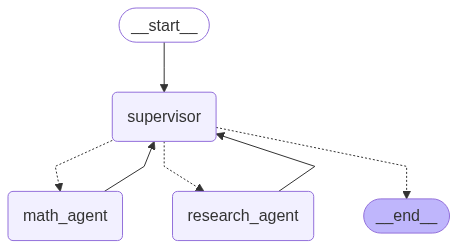

In [14]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
inputs = {
    "messages": [
        {
            "type": "human",
            "content": (
                "find the release year of the song named 'Unravel'.\n"
                "Multiply the release year by 2254.20 and add 289 to the output value. Then provide the final answer including the year and the output value.\n /no_think"
            )
        }
    ]
}

result = app.invoke(inputs)

In [ ]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

find the release year of the song named 'Unravel'.
Multiply the release year by 2254.20 and add 289 to the output value. Then provide the final answer including the year and the output value.
 /no_think
================================== Ai Message ==================================
Name: supervisor

<think>

</think>
Tool Calls:
  transfer_to_research_agent (chatcmpl-tool-ef44da93718f4f06b26fbd77ccc99452)
 Call ID: chatcmpl-tool-ef44da93718f4f06b26fbd77ccc99452
  Args:
================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent
================================== Ai Message ==================================
Name: research_agent

<think>

</think>
Tool Calls:
  tavily_search (chatcmpl-tool-54ac0c509d7c49779b408220905833ec)
 Call ID: chatcmpl-tool-54ac0c509d7c49779b408220905833ec
  Args:
    query: release yea